# Intro

We train mixture density network (https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) and a equivalent network using MC dropout (https://arxiv.org/pdf/1506.02142.pdf) on 1D toy data. As target distribution we choose the individual modes to be gaussians. We subsequently compare the uncertainty estimates for in and out of distribution samples

We will see that both uncertainty estimates complement each other. MDNs deliver a better estimate of the actual noise of the data. Whereas MC dropout yields a better estimate for the model uncertainty as can be seen in the uncertainty estimates on the out of distribution samples.

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [11]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3

# Training
X = np.random.uniform(0, max_tr, N)
Y = np.sin(X) + np.random.normal(loc=0, scale=sig1, size=N) + np.random.normal(loc=0, scale=sig2, size=N)

# Validation
X_val = np.random.uniform(min_val, max_val, N_val)
Y_val = np.sin(X_val) + np.random.normal(loc=0, scale=sig1, size=N_val) + np.random.normal(loc=0, scale=sig2, size=N_val)

# Out of distribution samples
X_test1 = np.random.uniform(min_val-10, min_val, int(N_val/2))
X_test2 = np.random.uniform(max_val, max_val+10, int(N_val/2))
X_test = np.concatenate([X_test1, X_test2], axis=0)
Y_test = np.sin(X_test) + np.random.normal(loc=0, scale=sig1, size=N_val) + \
            np.random.normal(loc=0, scale=sig2, size=N_val)

Visualize data

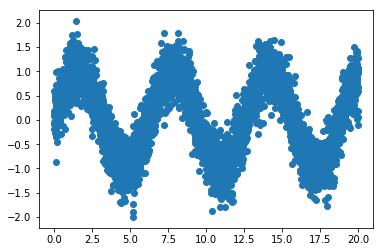

In [3]:
plt.figure()
plt.scatter(X, Y)
plt.show()

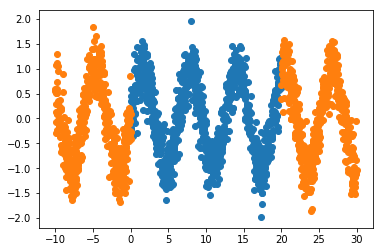

In [14]:
plt.figure()
plt.scatter(X_val, Y_val)
plt.scatter(X_test, Y_test)
plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [67]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1
dropout_rate = 0.1
mc_samples = 50

In [16]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :1]
    means = y_pred[:, :modes]
    std = tf.square(tf.exp(y_pred[:, modes:2*modes]))
    weights = y_pred[:, 2*modes:3*modes]
    
    modes_prob = []
    for i in range(modes):
        diff = tf.subtract(targets, means[:, i:(i+1)])
        m_loss_log = -1*tf.divide(tf.square(diff), 2*std[:, i:(i+1)]) - tf.sqrt(2*np.pi*std[:, i:(i+1)]) + tf.log(weights[:, i:(i+1)])
        modes_prob.append(m_loss_log)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [63]:
def get_model(mdn=False, dropout=False):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    if dropout:
        dense = Lambda(lambda x: K.dropout(x, level=dropout_rate))(dense)
    dense = Dense(100, activation='relu')(dense)
    if dropout:
        dense = Lambda(lambda x: K.dropout(x, level=dropout_rate))(dense)
    
    if not mdn:
        out = Dense(1)(dense)
    else:
        out_mean = Dense(modes)(dense)
        
        out_std = Dense(modes)(dense)
#         out_std = Lambda(lambda x: tf.abs(x))(out_std)
        
        out_weights = Dense(modes, activation='softmax')(dense)
#         out_weights = Lambda(lambda x: tf.abs(x)/(tf.reduce_sum(tf.abs(x))+1e-12))(out_weights)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit mixture density network to data

In [18]:
model_mdn = get_model(mdn=True, dropout=False)

In [19]:
model_mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          200         input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          10100       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          10100       dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (

In [20]:
Y_mdn = np.concatenate([np.reshape(Y, (Y.shape[0], 1)), np.zeros((Y.shape[0], modes*3-1))], axis=1)
Y_mdn_val = np.concatenate([np.reshape(Y_val, (Y_val.shape[0], 1)), np.zeros((Y_val.shape[0], modes*3-1))], axis=1)

model_mdn.fit(
    x = X,
    y = Y_mdn,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_mdn_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 134us/step - loss: 8.8698 - val_loss: 2.5239
Epoch 2/1000
4000/4000 [==============================] - 0s 38us/step - loss: 2.4478 - val_loss: 2.3865
Epoch 3/1000
4000/4000 [==============================] - 0s 36us/step - loss: 2.3841 - val_loss: 2.3312
Epoch 4/1000
4000/4000 [==============================] - 0s 39us/step - loss: 2.3232 - val_loss: 2.2782
Epoch 5/1000
4000/4000 [==============================] - 0s 47us/step - loss: 2.2903 - val_loss: 2.2710
Epoch 6/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.2712 - val_loss: 2.2267
Epoch 7/1000
4000/4000 [==============================] - 0s 38us/step - loss: 2.2591 - val_loss: 2.2074
Epoch 8/1000
4000/4000 [==============================] - 0s 37us/step - loss: 2.2175 - val_loss: 2.1981
Epoch 9/1000
4000/4000 [==============================] - 0s 37us/step - loss: 2.2032 - val_loss: 2.1617
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.9426 - val_loss: 1.9238
Epoch 79/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.9562 - val_loss: 1.9244
Epoch 80/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.9505 - val_loss: 1.9579
Epoch 81/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.9420 - val_loss: 1.9357
Epoch 82/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.9398 - val_loss: 1.9316
Epoch 83/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.9363 - val_loss: 1.9311
Epoch 84/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.9354 - val_loss: 1.9313
Epoch 85/1000
4000/4000 [==============================] - 0s 42us/step - loss: 1.9463 - val_loss: 1.9138
Epoch 86/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.9351 - val_loss: 1.9156
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.8152 - val_loss: 1.7706
Epoch 156/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.8080 - val_loss: 1.7850
Epoch 157/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.8021 - val_loss: 1.7674
Epoch 158/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.8105 - val_loss: 1.7773
Epoch 159/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.8135 - val_loss: 1.8461
Epoch 160/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.8024 - val_loss: 1.7789
Epoch 161/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.8063 - val_loss: 1.7555
Epoch 162/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.7982 - val_loss: 1.7666
Epoch 163/1000
4000/4000 [==============================] - 0s 35us/step - loss: 1.7961 - val_loss: 1.7751
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 34us/step - loss: 1.4897 - val_loss: 1.4603
Epoch 232/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.5207 - val_loss: 1.5195
Epoch 233/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.5003 - val_loss: 1.5304
Epoch 234/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.5056 - val_loss: 1.4847
Epoch 235/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.5074 - val_loss: 1.4588
Epoch 236/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.4863 - val_loss: 1.4787
Epoch 237/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.4903 - val_loss: 1.4453
Epoch 238/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.4828 - val_loss: 1.4746
Epoch 239/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.5040 - val_loss: 1.4424
Epoch 240/1000
4000/4000 [==========================

4000/4000 [==============================] - 0s 36us/step - loss: 1.3507 - val_loss: 1.3301
Epoch 308/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.3206 - val_loss: 1.3168
Epoch 309/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.3273 - val_loss: 1.4010
Epoch 310/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.3502 - val_loss: 1.3117


Visualize prediction

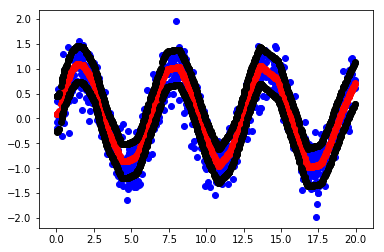

In [32]:
preds_mdn = model_mdn.predict(X_val)

preds_mdn_means = preds_mdn[:, :modes]
preds_mdn_stds = preds_mdn[:, modes:2*modes]
preds_mdn_weights = preds_mdn[:, 2*modes:3*modes]

preds_mdn_final = np.sum(preds_mdn_means*preds_mdn_weights, axis=1)
std_mdn_final = np.exp(np.sum(preds_mdn_stds*preds_mdn_weights, axis=1))

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds_mdn_final, color='r')
plt.scatter(X_val, preds_mdn_final + std_mdn_final, color='k')
plt.scatter(X_val, preds_mdn_final - std_mdn_final, color='k')
plt.show()

In [33]:
print('Mean sigma:')
print(std_mdn_final.mean())

Mean sigma:
0.3689293


Fit normal dense network with mc dropout to data

In [68]:
model_mc = get_model(mdn=False, dropout=True)

In [69]:
model_mc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
lambda_10 (Lambda)           (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
lambda_11 (Lambda)           (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 101       
Total para

In [70]:
model_mc.fit(
    x = X,
    y = Y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 139us/step - loss: 0.6488 - val_loss: 0.5844
Epoch 2/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.6011 - val_loss: 0.5543
Epoch 3/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.5709 - val_loss: 0.5313
Epoch 4/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5498 - val_loss: 0.5217
Epoch 5/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.5301 - val_loss: 0.5083
Epoch 6/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5205 - val_loss: 0.5063
Epoch 7/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.5174 - val_loss: 0.5090
Epoch 8/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5166 - val_loss: 0.5053
Epoch 9/1000
4000/4000 [==============================] - 0s 34us/step - loss: 0.5097 - val_loss: 0.5018
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2639 - val_loss: 0.2446
Epoch 79/1000
4000/4000 [==============================] - 0s 33us/step - loss: 0.2575 - val_loss: 0.2465
Epoch 80/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.2500 - val_loss: 0.2440
Epoch 81/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2519 - val_loss: 0.2560
Epoch 82/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2467 - val_loss: 0.2427
Epoch 83/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2409 - val_loss: 0.2518
Epoch 84/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.2527 - val_loss: 0.3017
Epoch 85/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2468 - val_loss: 0.2313
Epoch 86/1000
4000/4000 [==============================] - 0s 34us/step - loss: 0.2386 - val_loss: 0.2186
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.1427 - val_loss: 0.1318
Epoch 156/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.1410 - val_loss: 0.1368
Epoch 157/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.1599 - val_loss: 0.1747
Epoch 158/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.1593 - val_loss: 0.1432
Epoch 159/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.1415 - val_loss: 0.1234
Epoch 160/1000
4000/4000 [==============================] - 0s 33us/step - loss: 0.1503 - val_loss: 0.1370
Epoch 161/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.1449 - val_loss: 0.1435
Epoch 162/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.1437 - val_loss: 0.1427
Epoch 163/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.1404 - val_loss: 0.1356
Epoch 164/1000
4000/4000 [===========

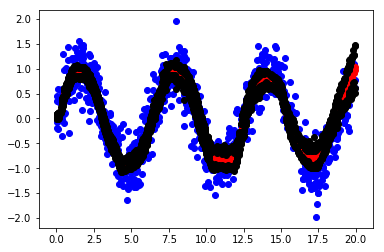

In [71]:
preds_mc = []
for i in range(mc_samples):
    preds_mc.append(model_mc.predict(X_val))
preds_mc = np.concatenate(preds_mc, axis=1)
preds_mc_mean = preds_mc.mean(axis=1)
preds_mc_std = preds_mc.std(axis=1)

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds_mc_mean, color='r')
plt.scatter(X_val, preds_mc_mean + preds_mc_std, color='k')
plt.scatter(X_val, preds_mc_mean - preds_mc_std, color='k')
plt.show()

In [72]:
print('Mean Sigmas:')
print(preds_mc_std.mean(axis=0))

Mean Sigmas:
0.14776517


# Error comparison

Comparing the errors of normal model vs. mdn

In [73]:
error = np.mean(np.abs(preds_mdn_final - Y_val))
error_mdn = np.mean(np.abs(preds_mc_mean - Y_val))

print('Error MDN: ' + str(error_mdn))
print('Error MC: ' + str(error))

Error MDN: 0.2618186966382706
Error MC: 0.25416196175180367


# Visualize uncertainty estimate

Variance depending on prediction error for MDN

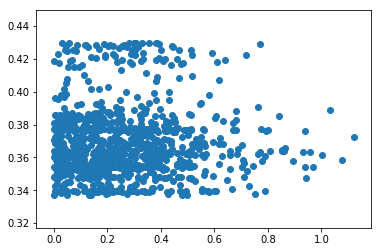

In [75]:
plt.figure()
plt.scatter(np.abs(preds_mdn_final - Y_val), std_mdn_final)
plt.show()

Variance depending on prediction error for MC dropout

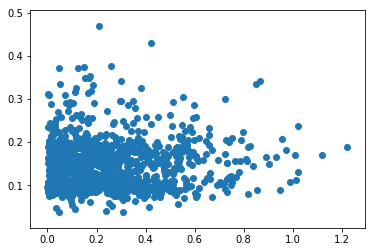

In [77]:
plt.figure()
plt.scatter(np.abs(preds_mc_mean - Y_val), preds_mc_std)
plt.show()

# Run on out of distribution samples X_test

MDN

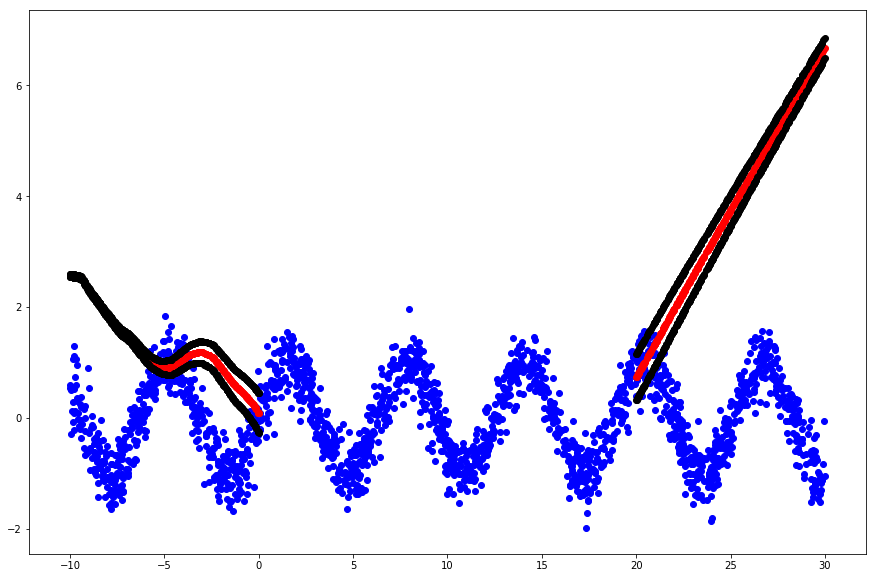

In [81]:
preds_mdn = model_mdn.predict(X_test)

preds_mdn_means = preds_mdn[:, :modes]
preds_mdn_stds = preds_mdn[:, modes:2*modes]
preds_mdn_weights = preds_mdn[:, 2*modes:3*modes]

preds_mdn_final = np.sum(preds_mdn_means*preds_mdn_weights, axis=1)
std_mdn_final = np.exp(np.sum(preds_mdn_stds*preds_mdn_weights, axis=1))

plt.figure(figsize=(15,10))
plt.scatter(X_test, Y_test, color='b')
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_test, preds_mdn_final, color='r')
plt.scatter(X_test, preds_mdn_final + std_mdn_final, color='k')
plt.scatter(X_test, preds_mdn_final - std_mdn_final, color='k')
plt.show()

In [83]:
print('Mean sigma:')
print(std_mdn_final.mean())

Mean sigma:
0.2229317


MC dropout

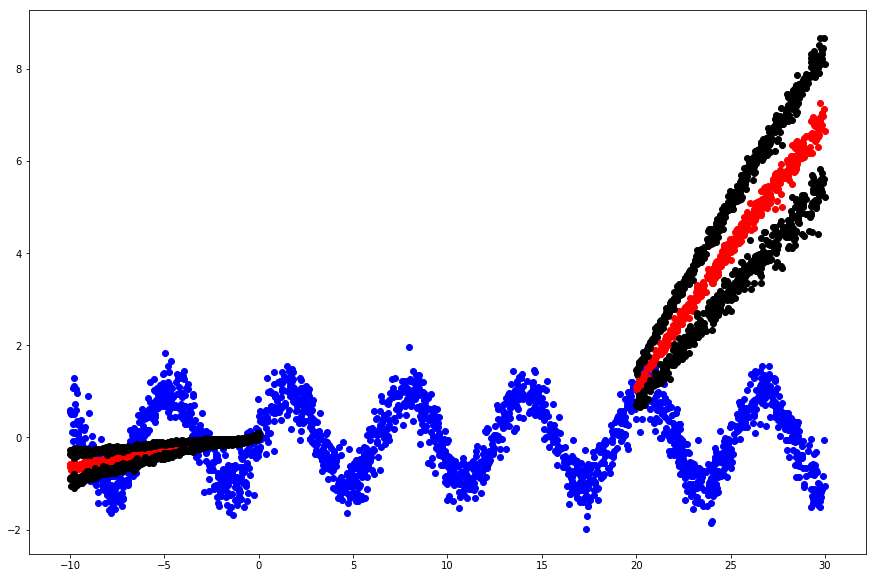

In [82]:
preds_mc = []
for i in range(mc_samples):
    preds_mc.append(model_mc.predict(X_test))
preds_mc = np.concatenate(preds_mc, axis=1)
preds_mc_mean = preds_mc.mean(axis=1)
preds_mc_std = preds_mc.std(axis=1)

plt.figure(figsize=(15,10))
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_test, Y_test, color='b')
plt.scatter(X_test, preds_mc_mean, color='r')
plt.scatter(X_test, preds_mc_mean + preds_mc_std, color='k')
plt.scatter(X_test, preds_mc_mean - preds_mc_std, color='k')
plt.show()

In [84]:
print('Mean Sigmas:')
print(preds_mc_std.mean(axis=0))

Mean Sigmas:
0.53335375
